# Random Forest regressor

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor


from statsmodels.tools.eval_measures import stde




## Read the etl info results

In [2]:
df_info = pd.read_csv('../dataset_clean/options_csv_v1_etl.csv')
df_info

,remove_time_features,generic_features,remove_atypical_values,feature_combination,remove_feature_selection,remove_invalid_correlated_features
0,False,True,False,False,False,False


## Read the dataset

In [3]:
df = pd.read_csv('../dataset_clean/PlatteRiverWeir_features_v1_clean.csv')
df

,SensorTime,CaptureTime,Stage,Discharge,grayMean,graySigma,entropyMean,entropySigma,hMean,hSigma,sMean,sSigma,vMean,vSigma
0,2012-06-09 13:15:00,2012-06-09T13:09:07,2.99,916.0,97.405096,39.623303,0.203417,0.979825,105.368375,41.572939,124.520218,4.111846,132.405971,14.983367
1,2012-06-09 13:15:00,2012-06-09T13:10:29,2.99,916.0,104.066757,40.179745,0.206835,1.002624,112.399458,41.795584,124.317679,4.270429,133.070221,15.334166
2,2012-06-09 13:45:00,2012-06-09T13:44:01,2.96,873.0,105.636831,40.533218,0.204756,0.994246,114.021526,42.145582,124.304621,4.310293,133.294541,15.502448
3,2012-06-09 14:45:00,2012-06-09T14:44:30,2.94,846.0,104.418949,41.752678,0.202428,0.983170,112.612830,43.575351,124.369736,4.120586,133.458381,15.190064
4,2012-06-09 15:45:00,2012-06-09T15:44:59,2.94,846.0,106.763541,44.442097,0.202661,0.989625,114.839424,46.302008,124.283191,4.088480,133.573595,14.801143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42054,2019-10-11 09:00:00,2019-10-11T08:59:53,2.54,434.0,82.872720,57.702652,0.221708,1.076393,87.260572,61.485334,127.807813,2.564157,124.073149,13.757842
42055,2019-10-11 10:00:00,2019-10-11T09:59:52,2.54,434.0,89.028383,55.840861,0.233168,1.124774,94.175906,59.006132,127.336000,2.585121,124.882812,13.234735
42056,2019-10-11 11:00:00,2019-10-11T10:59:52,2.54,434.0,94.722097,54.355753,0.240722,1.151833,100.534577,56.921028,126.958768,2.774867,126.145409,13.408480
42057,2019-10-11 12:00:00,2019-10-11T11:59:53,2.54,434.0,96.693270,52.787629,0.244789,1.171987,102.891159,55.083532,126.679956,2.998683,127.508063,13.863205


In [4]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year
df['Month'] = df['SensorTime'].dt.month

In [5]:
df.dtypes

SensorTime      datetime64[ns]
CaptureTime             object
Stage                  float64
Discharge              float64
grayMean               float64
graySigma              float64
entropyMean            float64
entropySigma           float64
hMean                  float64
hSigma                 float64
sMean                  float64
sSigma                 float64
vMean                  float64
vSigma                 float64
Year                     int64
Month                    int64
dtype: object

In [6]:
df = df[(df.Stage > 0) & (df.Discharge > 0)]

In [7]:
df.isna().sum()

SensorTime      0
CaptureTime     0
Stage           0
Discharge       0
grayMean        0
graySigma       0
entropyMean     0
entropySigma    0
hMean           0
hSigma          0
sMean           0
sSigma          0
vMean           0
vSigma          0
Year            0
Month           0
dtype: int64

## Divide dataset to X and Y

In [8]:
np.random.seed(0)

df_train = df[(df.Year >= 2012) & (df.Year <= 2017)]
df_train = df_train.iloc[np.random.permutation(len(df_train))]

df_test = df[(df.Year >= 2018) & (df.Year <= 2019)]

In [9]:
df_train = df_train.drop(columns=["Year", "SensorTime", "CaptureTime"])
#df_val = df_val.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_test = df_test.drop(columns=["Year", "SensorTime", "CaptureTime"])

In [10]:
y_train = df_train["Stage"]
X_train = df_train.drop(columns=["Stage", "Discharge"])

y_test = df_test["Stage"]
X_test = df_test.drop(columns=["Stage", "Discharge"])

In [11]:
print(X_train.shape)
print(y_train.shape)

(27421, 11)
(27421,)


In [12]:
input_shape = X_train.shape
output_shape = y_train.shape

print(input_shape, output_shape)

(27421, 11) (27421,)


## Train model

In [13]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestRegressor(random_state=0))
])

param_grid = {'clf__n_estimators': np.arange(50, 300, 1), 'clf__max_features': ["sqrt", 1.0, "log2"]}

clf = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=20, n_jobs=8, verbose=3, scoring="neg_mean_squared_error")

In [14]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 4/5] END clf__max_features=log2, clf__n_estimators=193;, score=-0.206 total time=  11.7s
[CV 3/5] END clf__max_features=log2, clf__n_estimators=193;, score=-0.190 total time=  11.7s
[CV 5/5] END clf__max_features=log2, clf__n_estimators=193;, score=-0.186 total time=  11.8s
[CV 1/5] END clf__max_features=log2, clf__n_estimators=193;, score=-0.201 total time=  12.0s
[CV 2/5] END clf__max_features=log2, clf__n_estimators=193;, score=-0.187 total time=  12.2s
[CV 2/5] END clf__max_features=log2, clf__n_estimators=206;, score=-0.187 total time=  12.6s
[CV 3/5] END clf__max_features=log2, clf__n_estimators=206;, score=-0.190 total time=  13.0s
[CV 1/5] END clf__max_features=log2, clf__n_estimators=206;, score=-0.201 total time=  13.3s
[CV 2/5] END clf__max_features=log2, clf__n_estimators=118;, score=-0.188 total time=   7.0s
[CV 1/5] END clf__max_features=log2, clf__n_estimators=118;, score=-0.201 total time=   7.2s
[CV 3/5]

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf',
                                              RandomForestRegressor(random_state=0))]),
                   n_iter=20, n_jobs=8,
                   param_distributions={'clf__max_features': ['sqrt', 1.0,
                                                              'log2'],
                                        'clf__n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90...
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
       258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270,
       271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283,
       284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296,
       297, 298, 299])},
                   scoring='neg_mean_squared_error', verbose=3)

## Test model

In [15]:
clf.best_score_

-0.18974709842322832

In [16]:
clf.best_params_

{'clf__n_estimators': 177, 'clf__max_features': 1.0}

In [17]:
clf.score(X_test, y_test)

-0.346428887134744

In [18]:
y_pred = clf.predict(X_test)

In [19]:
print("R^2: ", r2_score(y_test, y_pred))
print("mse: ", mean_squared_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("mape: ", mean_absolute_percentage_error(y_test, y_pred))
print("Error estandar: ", stde(y_test.squeeze(),
      y_pred.squeeze(), ddof=2))


R^2:  0.11294665850022367
mse:  0.346428887134744
rmse:  0.5885820988908378
mae:  0.38203317916134527
mape:  0.14412078605527165
Error estandar:  0.5452671219668532


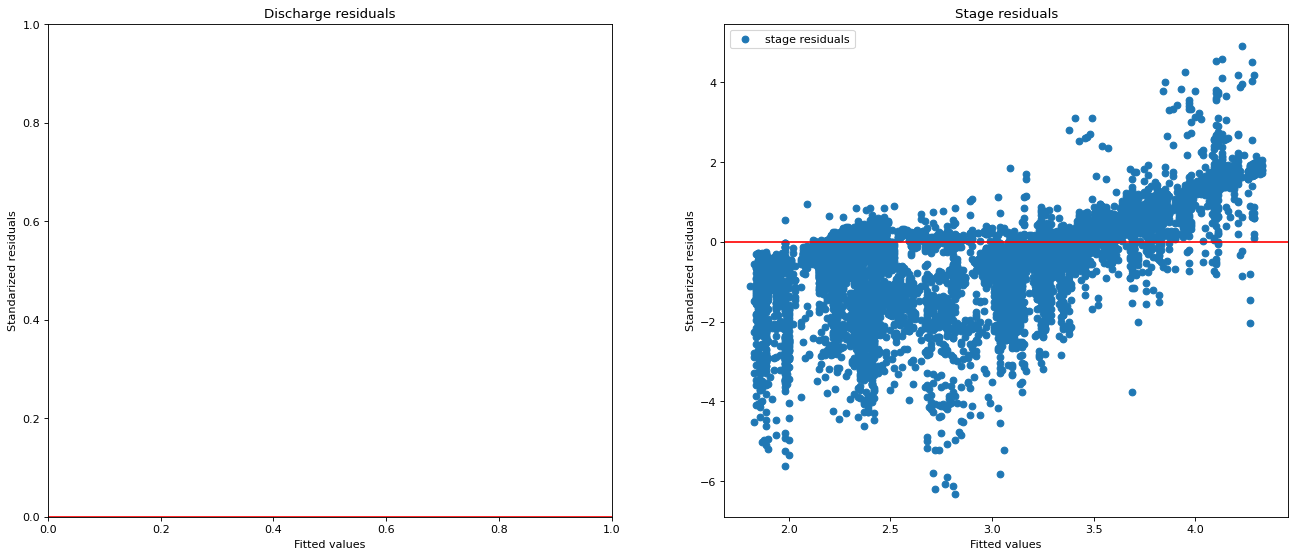

In [20]:
residuals = y_test - y_pred
residuals_std = residuals / residuals.std()

y_real_stage = y_test
residual_stage = residuals

#y_real_discharge = np.array([i[-1] for i in y_test])
#residual_discharge = np.array([i[-1] for i in residuals])


figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[1].scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
#ax[0].scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
ax[1].axhline(y=0.0, color='r', linestyle='-')
ax[0].axhline(y=0.0, color='r', linestyle='-')

ax[1].set_title("Stage residuals")
ax[0].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()

In [21]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad

#figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')
plt.show()

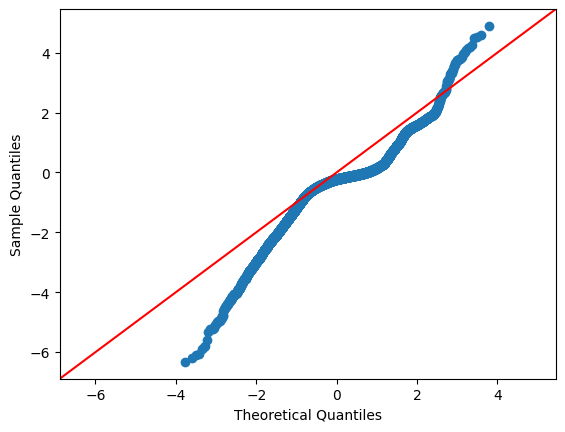

In [22]:
figure = sm.qqplot(residual_stage / residual_stage.std(), line='45', label='discharge')
plt.show()

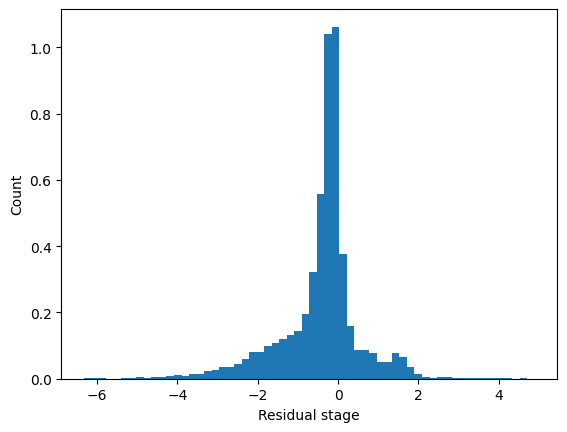

In [23]:
plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual stage');
plt.show()

In [24]:
"""plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()"""

"plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)\nplt.ylabel('Count')\nplt.xlabel('Residual discharge');\nplt.show()"

In [25]:
stat, pval = normal_ad(residual_stage / residual_stage.std())
print("p-value:", pval)

if pval < 0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")


p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


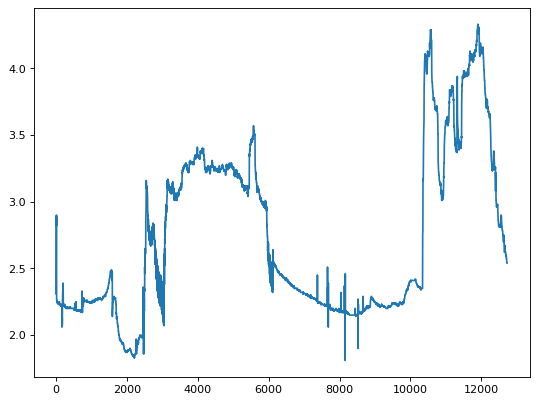

In [26]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(np.arange(len(y_test)), y_test, label="Stage real")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


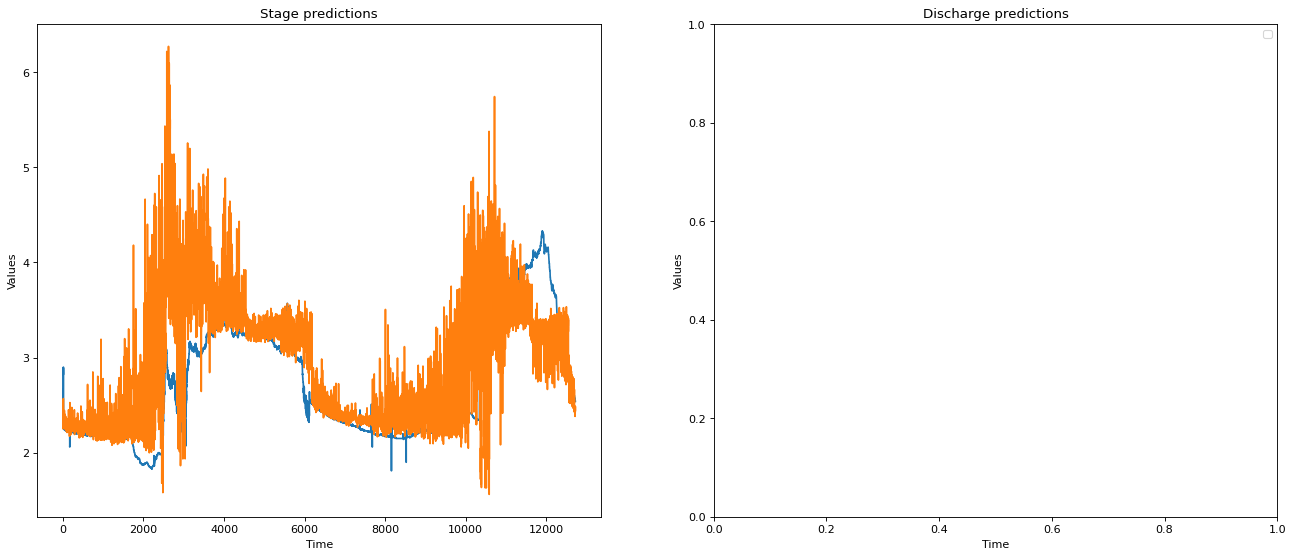

In [27]:
figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].plot(np.arange(len(y_test)), y_test, label="Stage real")
ax[0].plot(np.arange(len(y_test)), y_pred, label="Stage pred")

ax[0].set_title("Stage predictions")
ax[1].set_title("Discharge predictions")

ax[1].set_ylabel("Values")
ax[0].set_ylabel("Values")
ax[1].set_xlabel("Time")
ax[0].set_xlabel("Time")

plt.legend()
plt.show()